# Lesson 3 - Plannet

This is based on a [kaggle dataset](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space) where we are going to analyze a set of sat images.<br/>
In that each image is classified with multiple lables. So, we need to identify them properly.

## Downloading the dataset

For that we need to install the kaggle API download data like this: <br/>
First of all, we also need to install 7z support.

```shell
sudo apt-get -y install p7zip-full unzip
mkdir -p ~/data/planet
cd ~/data/planet
kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv
kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z

unzip train_v2.csv
7z e train-jpg.tar.7z
tar xf train-jpg.tar
```

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Inspect Data

Now we symlink this data directory this directory. <br/>
So, we can inspect it.

In [3]:
PATH = Path('data/planet'); PATH.ls()

[PosixPath('data/planet/train-jpg'),
 PosixPath('data/planet/test-jpg-additional'),
 PosixPath('data/planet/__MACOSX'),
 PosixPath('data/planet/test-jpg.tar.7z'),
 PosixPath('data/planet/test-jpg'),
 PosixPath('data/planet/test-jpg-additional.tar'),
 PosixPath('data/planet/train-jpg.tar'),
 PosixPath('data/planet/train_v2.csv.zip'),
 PosixPath('data/planet/test-jpg-additional.tar.7z'),
 PosixPath('data/planet/models'),
 PosixPath('data/planet/submission.csv'),
 PosixPath('data/planet/submission-load-data-then-model.csv'),
 PosixPath('data/planet/train-jpg.tar.7z'),
 PosixPath('data/planet/submission-load-model-then-data.csv'),
 PosixPath('data/planet/test-jpg.tar'),
 PosixPath('data/planet/train_v2.csv')]

In [4]:
train_csv_path=PATH/'train_v2.csv'
!head {train_csv_path}

image_name,tags
train_0,haze primary
train_1,agriculture clear primary water
train_2,clear primary
train_3,clear primary
train_4,agriculture clear habitation primary road
train_5,haze primary water
train_6,agriculture clear cultivation primary water
train_7,haze primary
train_8,agriculture clear cultivation primary


Each images has multiple tags.<br/>
Now let's have a look some image files.

In [5]:
train_image_path = PATH/'train-jpg'
train_fnames = train_image_path.ls()
train_fnames[:5]

[PosixPath('data/planet/train-jpg/train_9769.jpg'),
 PosixPath('data/planet/train-jpg/train_31128.jpg'),
 PosixPath('data/planet/train-jpg/train_36771.jpg'),
 PosixPath('data/planet/train-jpg/train_14103.jpg'),
 PosixPath('data/planet/train-jpg/train_25665.jpg')]

Now we've some idea of our data. So, based on that, we can create a DataBunch object and use that inside the learner.

## Creating the DataBunch

Let's create the databunch from the above dataset.<br/>
It's a multiclassification. So, we have a to use a different API([dataBlock](https://docs.fast.ai/data_block.html)) than what we did before.

In [6]:
# This is a set of transformation which is pretty good for sat images
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [7]:
data = (
    ImageItemList
        .from_csv(PATH, 'train_v2.csv', folder="train-jpg", suffix=".jpg")
        .random_split_by_pct(0.2)
        .label_from_df(sep=' ')
        .transform(tfms, size=128)
        .databunch()
        .normalize(imagenet_stats)
)

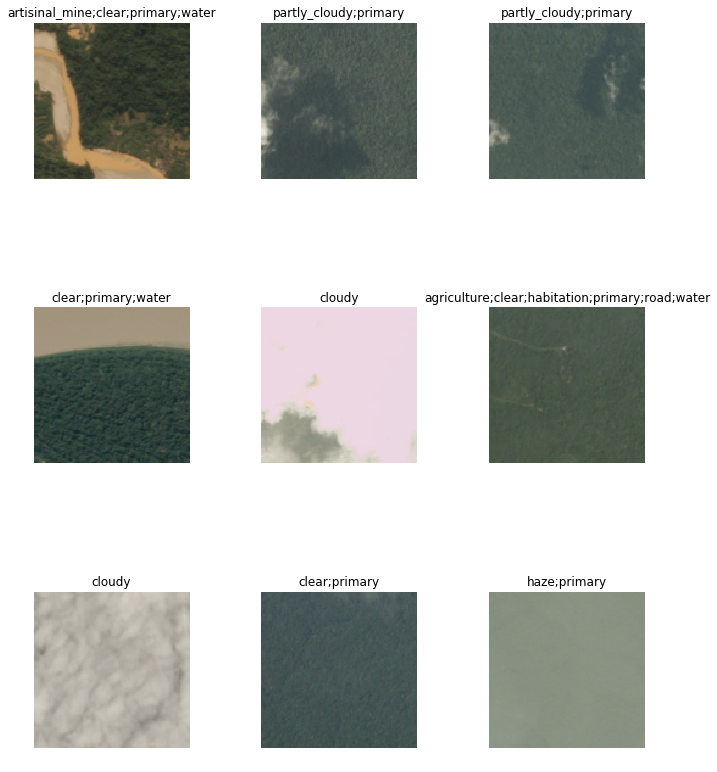

In [8]:
data.show_batch(rows=3, figsize=(10, 12))

## Initial Model

Now let's try to build our model.

In [9]:
# First of all, we need to find some metrics 
# Basically these are just for printing only.
# Since this is a multi classification problem, we need to use a threshold for the 
# accuracy.
def p_accuracy(pred, act, **kwargs):
    return accuracy_thresh(pred, act, thresh=0.2, **kwargs)

In [10]:
learn = create_cnn(data, models.resnet50, metrics=[p_accuracy])

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


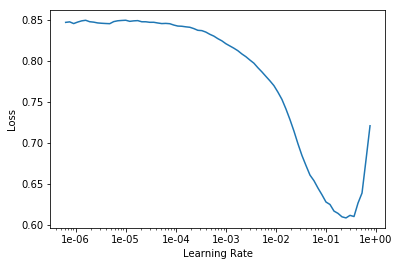

In [12]:
learn.recorder.plot()

In [13]:
lr = 0.01
learn.fit_one_cycle(5, slice(lr))

Total time: 03:15
epoch  train_loss  valid_loss  p_accuracy
1      0.115775    0.102709    0.947353    (00:40)
2      0.109179    0.099059    0.949787    (00:38)
3      0.103648    0.090533    0.953915    (00:39)
4      0.094335    0.086424    0.956560    (00:38)
5      0.087507    0.084721    0.957577    (00:38)



In [14]:
learn.save('l3-planet-base-freeze')

###  f2 score

This kaggle competition uses f2 score for the final eval.
So we should use that as well.

In [11]:
def f2_score(pred, act, **kwargs):
    return fbeta(pred, act, beta=2, thresh=0.2, **kwargs)

In [16]:
# Let's add that as an metric
learn.metrics = [p_accuracy, f2_score]

### Unfreezing

In [17]:
learn.unfreeze()

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


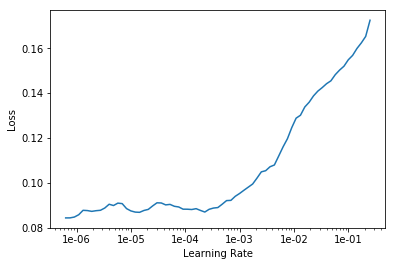

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

Total time: 04:06
epoch  train_loss  valid_loss  p_accuracy  f2_score
1      0.090530    0.084289    0.957236    0.927463  (00:48)
2      0.088612    0.083886    0.957759    0.927463  (00:48)
3      0.088079    0.083619    0.958842    0.928123  (00:49)
4      0.085543    0.083139    0.957425    0.928237  (00:49)
5      0.086393    0.083206    0.958406    0.928379  (00:49)



This is a pretty good result and we are on top 10% by default.

In [21]:
learn.save('l3-planet-base-freeze')

## Use Full Size Images

Here we've used the image size of 128px in the initial model. <br/>
That's simply because we want to try it out very quickly.

Now let's try to use the whole model.

In [22]:
learn.data = (
    ImageItemList
        .from_csv(PATH, 'train_v2.csv', folder="train-jpg", suffix=".jpg")
        .random_split_by_pct(0.2)
        .label_from_df(sep=' ')
        .transform(tfms, size=256)
        .databunch()
        .normalize(imagenet_stats)
)

In [23]:
learn.freeze()

See now we are using **transfer learning.** Instead of training from the beginning, we just start from model we trained with smaller images.

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


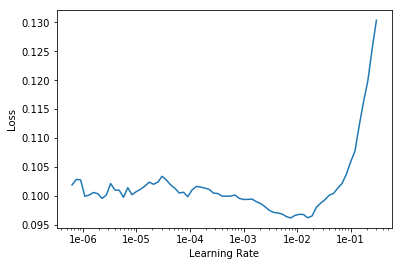

In [25]:
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(5, slice(1e-3))

Total time: 09:18
epoch  train_loss  valid_loss  p_accuracy  f2_score
1      0.092094    0.083121    0.958558    0.926407  (01:51)
2      0.089397    0.080557    0.959779    0.929749  (01:51)
3      0.085863    0.079771    0.959510    0.929781  (01:51)
4      0.086624    0.079305    0.959474    0.930336  (01:51)
5      0.083264    0.078933    0.959387    0.930922  (01:51)



In [27]:
learn.save('l3-planet-fullsize-freeze')

### Unfreezing

In [28]:
learn.unfreeze();

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


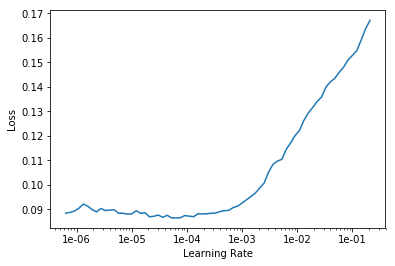

In [30]:
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(5, slice(1e-6, 1e-5))

Total time: 11:49
epoch  train_loss  valid_loss  p_accuracy  f2_score
1      0.084279    0.079210    0.960571    0.930227  (02:21)
2      0.086261    0.078712    0.959845    0.931399  (02:22)
3      0.085839    0.078929    0.960818    0.931017  (02:21)
4      0.085130    0.078996    0.960775    0.930672  (02:21)
5      0.085020    0.078632    0.960019    0.931245  (02:22)



In [32]:
learn.save('l3-planet-fullsize-unfreeze')

**This is a pretty amazing model** with the very little things we did.

## Test Dataset



In [12]:
# learn.load('l3-planet-fullsize-unfreeze'); 
data = (
    ImageItemList
        .from_csv(PATH, 'train_v2.csv', folder="train-jpg", suffix=".jpg")
        .random_split_by_pct(0.2)
        .label_from_df(sep=' ')
        .add_test_folder('test-jpg')
        .transform(tfms, size=256)
        .databunch()
        .normalize(imagenet_stats)
)
learn = create_cnn(data, models.resnet50, metrics=[p_accuracy, f2_score])

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


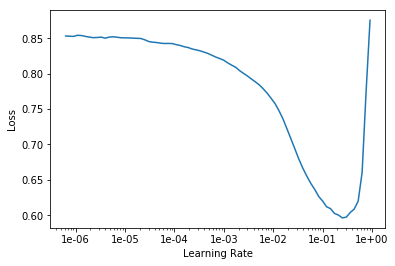

In [14]:
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(5, slice(1e-4, 1e-2))

Total time: 09:15
epoch  train_loss  valid_loss  p_accuracy  f2_score
1      0.117834    0.103928    0.948276    0.910065  (01:51)
2      0.107185    0.101703    0.953987    0.909127  (01:50)
3      0.099963    0.090390    0.951648    0.921290  (01:51)
4      0.093579    0.087231    0.953813    0.923600  (01:51)
5      0.090750    0.085548    0.956923    0.925079  (01:50)



In [31]:
learn.unfreeze()

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


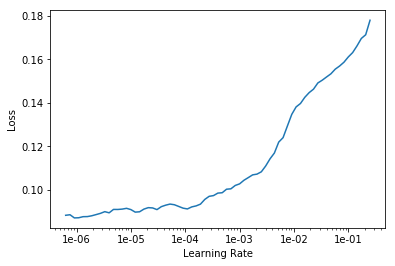

In [33]:
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(5, slice(1e-6, 1e-5))

Total time: 11:38
epoch  train_loss  valid_loss  p_accuracy  f2_score
1      0.087391    0.085532    0.956357    0.925052  (02:19)
2      0.089083    0.085234    0.956851    0.924169  (02:19)
3      0.090109    0.085115    0.956262    0.925426  (02:20)
4      0.089974    0.084623    0.957534    0.925493  (02:19)
5      0.086171    0.084797    0.957723    0.925444  (02:19)



In [37]:
learn.save('l3-planet-fullsize-unfreeze-from-scratch')

### Download test dataset

Use kaggle to download the test dataset. <br/>
Go to the `data/planet` directory and run following commands:

```
kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z
7z e test-jpg.tar.7z
tar xf test-jpg.tar

kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z
7z e test-jpg-additional.tar.7z
tar xf test-jpg.tar

mv test-jpg-additional/* test-jpg
```

In [16]:
# learn.data = (
#     ImageItemList
#         .from_csv(PATH, 'train_v2.csv', folder="train-jpg", suffix=".jpg")
#         .random_split_by_pct(0.2)
#         .label_from_df(sep=' ')
#         .add_test_folder('test-jpg')
#         .transform(tfms, size=256)
#         .databunch()
#         .normalize(imagenet_stats)
# )

In [17]:
!ls data/planet/test-jpg | wc

  61191   61191  895645


In [18]:
len(learn.data.test_ds)

61191

In [35]:
predictions = learn.get_preds(ds_type=DatasetType.Test)

/home/arunoda_susiripala/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/torch/nn/functional.py:1162: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [38]:
len(predictions[0])

61191

In [39]:
def find_tags(pred, thresh):
    classes = ""
    for idx, val in enumerate(pred):
        if val > thresh:
            classes = f'{classes} {learn.data.classes[idx]}'
    return classes.strip()

In [40]:
def predict(idx):
    pred_vals = predictions[0][idx]
    tags = find_tags(pred_vals, 0.2)
    print(tags)
    img = learn.data.test_ds[idx][0]
    return img

haze agriculture water partly_cloudy primary


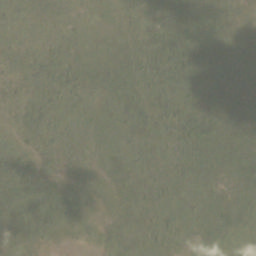

In [41]:
predict(0)

In [42]:
def get_row(idx):
    pred = predictions[0][idx]
    tags = find_tags(pred, 0.2)
    image_path = learn.data.test_ds.x.items[idx]
    image_name = re.search(r'([^/]+)$', f'{image_path}')[0].replace('.jpg', '')
    
    return image_name, tags

In [43]:
get_row(4)

('test_28867', 'partly_cloudy primary')

In [44]:
df = pd.DataFrame(columns=['image_name', 'tags'])
for idx in range(len(predictions[0])):
    if idx % 5000 == 0:
        print(f"Completed: {idx}")
        
    image_name, tags = get_row(idx)
    df.loc[idx] = [image_name, tags]

Completed: 0
Completed: 5000
Completed: 10000
Completed: 15000
Completed: 20000
Completed: 25000
Completed: 30000
Completed: 35000
Completed: 40000
Completed: 45000
Completed: 50000
Completed: 55000
Completed: 60000


In [45]:
df.head()

,image_name,tags
0,file_19658,haze agriculture water partly_cloudy primary
1,test_18775,agriculture water clear road habitation primary
2,file_20453,haze agriculture primary
3,test_23183,water clear primary
4,test_28867,partly_cloudy primary


In [46]:
submission_path = f'{PATH}/submission-train-unfreezed-256-size.csv'

In [47]:
df.to_csv(submission_path, index=False)

In [48]:
!head {submission_path}

image_name,tags
file_19658,haze agriculture water partly_cloudy primary
test_18775,agriculture water clear road habitation primary
file_20453,haze agriculture primary
test_23183,water clear primary
test_28867,partly_cloudy primary
test_17746,clear primary
test_11747,agriculture water clear primary
test_21382,blooming clear primary
test_10914,agriculture water cultivation clear primary


### Upload to kaggle

You can use the following command to upload our submission to kaggle.

```
kaggle competitions submit -c planet-understanding-the-amazon-from-space -f submission.csv -m "Message"
```